# Data loading

In [99]:
import pandas as pd
raw_data=pd.read_csv("comptage-velo-donnees-compteurs.csv",sep=";")

data=raw_data.loc[:,["id","sum_counts","date","coordinates"]]
data=data.rename(columns={"sum_counts":"counts"})

data=data.drop(data[data.coordinates.isnull()].index,axis=0)
#FURHTER EXPLORE: there are counters with isnull().sum()!=0 Always the same? Interpolate or equal 0?

data=data.astype({"id":int})

#Only care relative time (people always go to work at 8am, dont care about UTC)
split_date=data["date"].str.split("+",expand=True)
data["date"]=split_date[0]
data["UTC+"]=split_date[1]
data["date"]=pd.to_datetime(data['date'])#,utc=True)
# format='%Y-%m-%dT%H:%M:%S%z'

data["day"]=data['date'].dt.date
data["hour"]=data["date"].dt.hour #Since data.date.dt.minute.sum()=0, dont care about else

data[["lat","lon"]]=data["coordinates"].str.split(",",expand=True).astype(float)
data["coordinates"]=data["coordinates"].str.split(",",expand=False)
data["coordinates"].apply(lambda x: [float(x[0]),float(x[1])])

data["weekend"]=data["date"].dt.weekday>4

unique_index=[data[data["id"]==_id].index[0] for _id in data["id"].unique()]
station_data=data.loc[unique_index,['id','coordinates','lat','lon']]
station_data=station_data.set_index("id")

# Data exploration

<Axes: xlabel='date'>

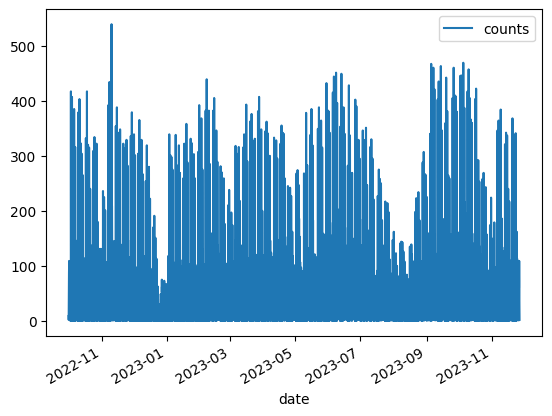

In [58]:
station_test=data[data["id"]==data["id"][0]]
station_test.plot(x="date",y="counts")

Text(0.5, 1.0, 'Number of stations')

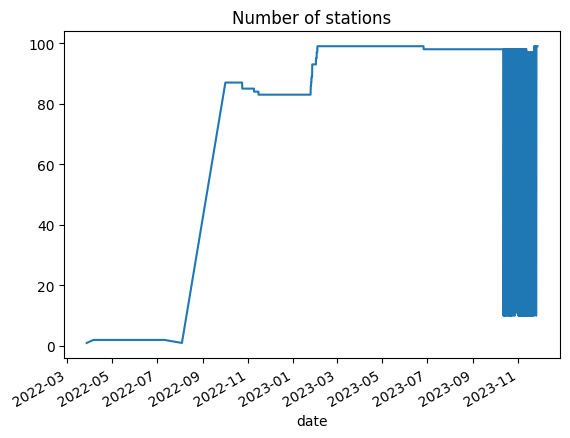

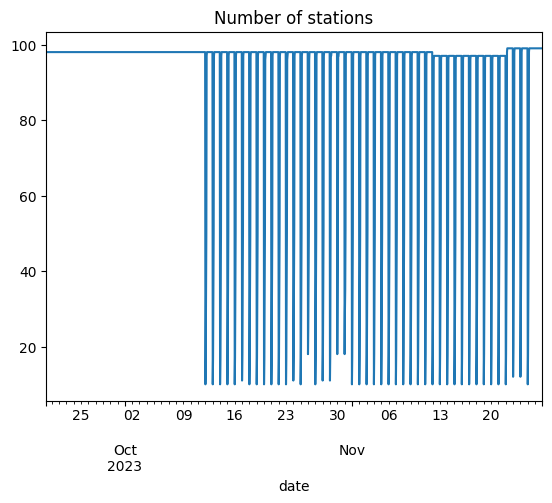

In [82]:
import matplotlib.pyplot as plt
data.groupby("date")["id"].count().plot().set_title("Number of stations")
plt.figure()
data.groupby("date")["id"].count().iloc[8500:].plot().set_title("Number of stations")

<Axes: xlabel='date'>

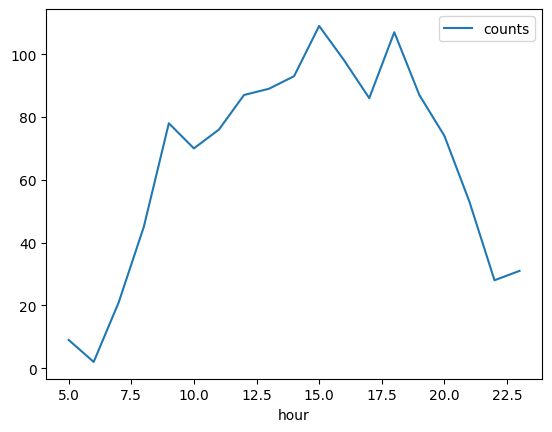

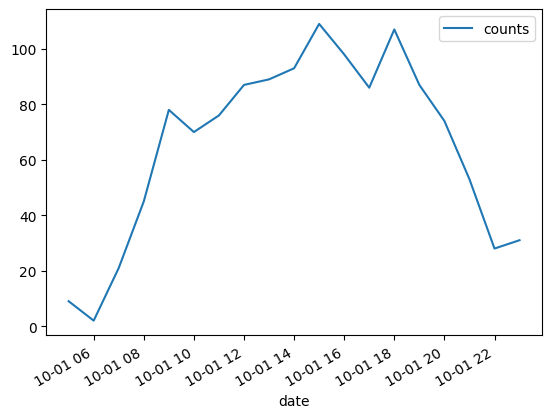

In [59]:
day_station_test=station_test[station_test["day"]==station_test["day"][0]]
day_station_test.sort_values("hour").plot(x="hour",y="counts",)
day_station_test.plot(x="date",y="counts")

<Axes: xlabel='hour'>

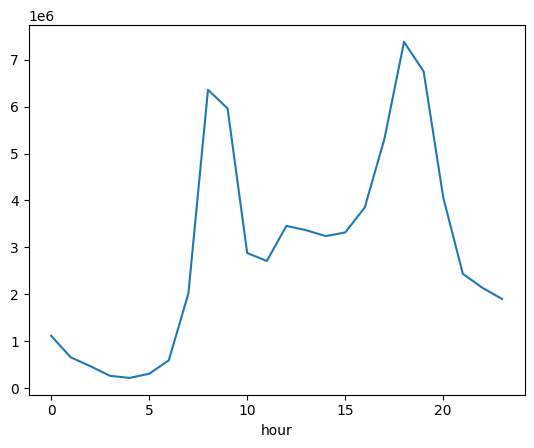

In [60]:
traffic_pattern=data.groupby("hour")["counts"].sum()
traffic_pattern.plot()

Text(0.5, 1.0, 'Traffic flow simulation')

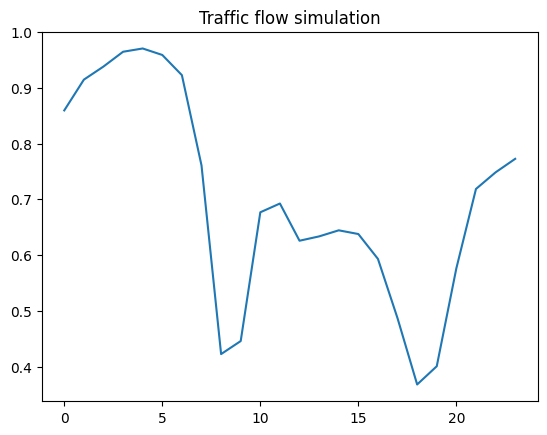

In [61]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.exp(-traffic_pattern/traffic_pattern.max()))
plt.title("Traffic flow simulation")

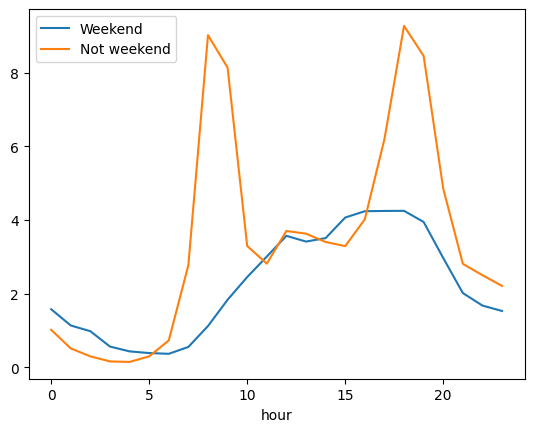

In [62]:
weekend=data[data["weekend"]==True]
(weekend.groupby("hour")["counts"].sum()/len(weekend)).plot(label=("Weekend"))

nonweekend=data[data["weekend"]==False]
(nonweekend.groupby("hour")["counts"].sum()/len(nonweekend)).plot(label=("Not weekend"))

plt.legend();


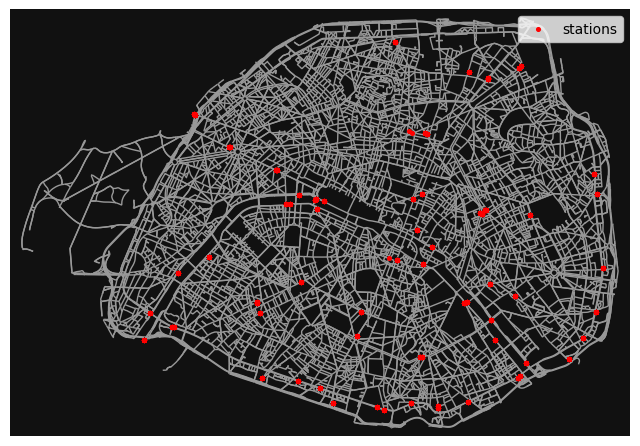

In [63]:
import osmnx as ox
map = ox.graph_from_place('Paris, France', network_type='drive',simplify=True)

fig,ax=ox.plot_graph(map,show=False, close=False,node_size=0)
data.plot.scatter(x="lon",y="lat",ax=ax,c="red",s=7,label="stations")

plt.legend();

# Route generator:

In [70]:
import osmnx as ox
G = ox.graph_from_place('Paris, France', network_type='drive',simplify=True)

In [99]:
def edges_to_nodes(track):
    return [edge[0] for edge in track]

def nodes_to_edges(track):
    return [(track[i],track[i+1]) for i in range(len(track)-1)]

In [101]:
def l_excess_backtrack(index,edges,l_excess,depth=0):
    """
    Given a list of edges and a length recursively traverses the
    edges until the length is covered

    Returns the next edge after traversing l_excess, current l_excess (<l),
    the depth of the backtrack return and a control bool that states if the track is finished.
    If l_excess is bigger than the remaining track length, returns last edge in the track with
    control bool True.
    """
    
    edge=edges[index]
    edge_info=G[edge[0]][edge[1]][0]
    l=edge_info["length"]
    if l_excess>l:
        l_excess-=l
        if (index+1)<len(edges):
            return l_excess_backtrack(index+1,edges,l_excess,depth+1)
        else:
            return edge, l_excess, depth, True
    else:
        return edge, l_excess, depth, False

In [97]:

from datetime import datetime
def generate_time_v1(G,track,start_t,sampling_rate=1,v0=20):
    """
    Adds timestemps to a list of nodes every samping_rate seconds
    simulating a movement at constant speed v0 [km/h]
    """   
    edge_list=nodes_to_edges(track)
    extended_track=[]
    edge_index=0
    t=start_t
    edge=edge_list[0]
    l_excess=0
    done=False
    while not done:
        
        l_excess+=sampling_rate*(v0/3.6)

        edge, l_excess, depth, done = l_excess_backtrack(edge_index,edge_list,l_excess)
        edge_index+=depth
        
        osmid=G[edge[0]][edge[1]][0]['osmid']
        x=[t,edge[0],edge[1],osmid]
        extended_track.append(x)

        t+=sampling_rate

    return extended_track

In [96]:

from datetime import datetime
def generate_time_v0(G,track,start_t,sampling_rate=1,v0=20):
    """
    Adds timestemps to a list of nodes every samping_rate seconds
    simulating a movement at constant speed v0 [km/h]
    """   
    extended_track=[]
    edge_list=nodes_to_edges(track)
    edge_index=0
    t=start_t
    t_enter_edge=t
    edge=edge_list[0]
    while edge!=edge_list[-1]:
        edge_info=G[edge[0]][edge[1]][0]

        l_traversed=(t-t_enter_edge)*(v0/3.6)
        l=edge_info["length"]
        if l_traversed>l:
            edge_index+=1
            edge=edge_list[edge_index]
            
            l_traversed-=l
            t_enter_edge=t
            #TODO: Asumes that the l excess fits in the next edge, but maybe no.
            #But next iter it checks if l_t>l and changes edge, but should not add time...
        osmid=edge_info['osmid']
        x=[t,edge[0],edge[1],osmid]
        extended_track.append(x)

        t+=sampling_rate

    return extended_track

In [94]:
import networkx as nx
from numpy.random import choice
def route_generator_v0(G,n=10,max_iter_factor=10,
                       start_t=None, data_every_t=24*3600, sampling_rate=1,
                       debug=False):
    """
    Generates a lsit of routes by selecting random points in the graph "G".

    Returns a list of n trajectories T.
    Each trajectory T[i] is a list of list elements in the format:
    [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

    If there is not a path between selected nodes (not connected graph) it retries new nodes.
    A budget of n*max_iter_factor retries is set to avoid infinite loop.
    """

    if not start_t:
        start_t=datetime.today().timestamp()

    T=[]
    max_counts=n*max_iter_factor
    counts=0
    t=start_t
    while len(T)<n:
        try:
            orig=choice(list(G.nodes()))
            dest=choice(list(G.nodes()))
            track=nx.shortest_path(G, orig, dest, weight='length')
            extended_track=generate_time_v1(G,track,t,sampling_rate=sampling_rate)
            T.append(extended_track)
            t+=data_every_t
        except nx.exception.NetworkXNoPath:
            if debug:
                print(f"Repeating {len(T)}th trajectory...")
            else:
                pass

        counts+=1
        if counts==max_counts:
            print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.")
            break

    if debug:
        print("Generation done.") 
    return T

In [103]:
T=route_generator_v0(G,n=100,debug=True)

Repeating 76th trajectory...
Repeating 77th trajectory...
Generation done.


In [84]:
import networkx as nx
from numpy.random import choice
def route_generator_v1(G,
                       node_selector,time_generator,
                       n=10,max_iter_factor=10,
                       start_t=None, data_every_t=24*3600, sampling_rate=1,
                       debug=False,
                       **kwargs):
    """
    Generates a list of routes with points selected with the node_selector
    and with time simulated by the time_generator.

    Returns a list of n trajectories T.
    Each trajectory T[i] is a list of list elements in the format:
    [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

    If there is not a path between selected nodes (not connected graph) it retries new nodes.
    A budget of n*max_iter_factor retries is set to avoid infinite loop.
    """

    if not start_t:
        start_t=datetime.today().timestamp()

    T=[]
    max_counts=n*max_iter_factor
    counts=0
    t=start_t
    while len(T)<n:
        try:
            orig,dest = node_selector(G,**kwargs)

            track=nx.shortest_path(G, orig, dest, weight='length')
            extended_track=time_generator(G,track,t,sampling_rate=sampling_rate,**kwargs)
            T.append(extended_track)
            t+=data_every_t
        except nx.exception.NetworkXNoPath:
            if debug:
                print(f"Repeating {len(T)}th trajectory...")
            else:
                pass

        counts+=1
        if counts==max_counts:
            print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.")
            break

    if debug:
        print("Generation done.") 
    return T

T=route_generator_v0(G,n=1,debug=True)

NameError: name 'route_generator_v0' is not defined

In [80]:
from numpy.random import choice
def node_selector_v0(G,**kwargs):
    """
    Selects two nodes at random from the map G with uniform probability
    """
    orig=choice(list(G.nodes()))
    dest=choice(list(G.nodes()))
    return orig,dest

Link station lat/lon to node

In [72]:
X=station_data["lon"]
Y=station_data["lat"]
station_data["closest_node"]=None
station_data["node_distance"]=np.inf
for node in G.nodes():
    node_data=G.nodes[node]
    x_0=node_data['x']
    y_0=node_data['y']
    d_2=(X-x_0)**2+(Y-y_0)**2

    better_index=d_2<station_data["node_distance"]
    station_data.loc[better_index,"closest_node"]=node
    station_data.loc[better_index,"node_distance"]=d_2
station_data=station_data.drop("node_distance",axis=1)

In [77]:
def get_p_v1(date):
    """
    Retrieves the nodes and relative frequency of counts for a given date,
    using only the nodes with a counter.
    *Note that all dates don't have info for all counters, need to use the returned nodes
    """
    date_subdata=data[data["date"].values==date]
    counts=date_subdata.groupby("id")['counts'].sum()
    counts/=counts.sum()

    nodes=station_data.loc[counts.index,"closest_node"].to_list()

    return nodes,counts

In [81]:
from numpy.random import choice
def node_selector_v1(G,date,**kwargs):
    """
    Selects two nodes at random from the map G with probability drawn from data
    """
    nodes,p=get_p_v1(date)
    orig=choice(nodes,p=p)
    dest=choice(nodes,p=p)
    #TODO: remove orig and its p from list after drawn, dont want point to point paths!
    return orig, dest

Issue: Counters have more than one counter!

"A metering site may be equipped with a meter in the case of a one-way bike development or two meters in the case of a bi-directional cycling development."

In [49]:
test_date=data[data["date"].values==data["date"][0]]
i_rep=[]
id_rep=[]
for i in range(len(test_date)):
    if len(test_date[test_date["id"]==test_date["id"].iloc[i]])>1:
        id_rep.append(test_date["id"].iloc[i])
        i_rep.append(i)
id_rep=np.unique(id_rep)
raw_data.loc[(test_date[test_date["id"]==id_rep[1]]).index]

,id_compteur,nom_compteur,id,name,sum_counts,date,installation_date,url_photos_n1,coordinates,counter,photos,test_lien_vers_photos_du_site_de_comptage_,id_photo_1,url_sites,type_dimage,mois_annee_comptage
50709,100036718-104036718,39 quai François Mauriac NO-SE,100036718.0,39 quai François Mauriac,5,2022-10-01T06:00:00+02:00,2017-07-12,https://filer.eco-counter-tools.com/file/d4/e8...,"48.83436,2.377",Y2H21015068,https://filer.eco-counter-tools.com/file/d4/e8...,https://filer.eco-counter-tools.com/file/d4/e8...,https:,https://www.eco-visio.net/Photos/100036718,jpg,2022-10
60426,100036718-103036718,39 quai François Mauriac SE-NO,100036718.0,39 quai François Mauriac,6,2022-10-01T06:00:00+02:00,2017-07-12,https://filer.eco-counter-tools.com/file/d4/e8...,"48.83436,2.377",Y2H21015068,https://filer.eco-counter-tools.com/file/d4/e8...,https://filer.eco-counter-tools.com/file/d4/e8...,https:,https://www.eco-visio.net/Photos/100036718,jpg,2022-10


# HEATMAP

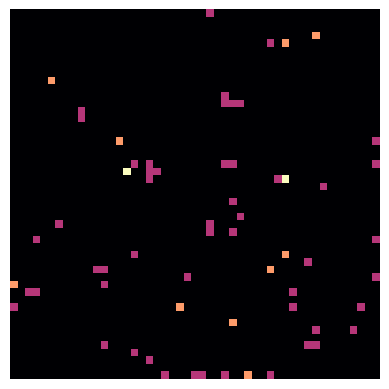

In [65]:
# data
unique_data=data.loc[unique_index,:]
latlon=np.array([unique_data["lat"],unique_data["lon"]]).T

# cut off long distance trips
# lat_low, lat_hgh = np.percentile(latlon[:,0], [2, 98])
# lon_low, lon_hgh = np.percentile(latlon[:,1], [2, 98])
lat_low=min(latlon[:,0]); lat_hgh=max(latlon[:,0])
lon_low=min(latlon[:,1]); lon_hgh=max(latlon[:,1])

# create image
bins = 50
lat_bins = np.linspace(lat_low, lat_hgh, bins)
lon_bins = np.linspace(lon_low, lon_hgh, bins)
H2, _, _ = np.histogram2d(latlon[:,0], latlon[:,1], bins=(lat_bins, lon_bins))

img = np.log(H2[::-1, :] + 1)

# plot
plt.figure()
ax = plt.subplot(1,1,1)

plt.imshow(img,cmap="magma")
plt.axis('off');

In [95]:
import matplotlib.pyplot as plt
def heatmap_from_tracks(T,G,quality_points=100):
    # data
    unique_data=data.loc[unique_index,:]
    latlon=[]
    for t in T:
        nodes=np.unique([P[1] for P in t])
        for node in nodes:
            node_data=G.nodes[node]
            lon=node_data['x']
            lat=node_data['y']
            latlon.append([lat,lon])
    latlon=np.array(latlon)


    # cut off long distance trips
    # lat_low, lat_hgh = np.percentile(latlon[:,0], [2, 98])
    # lon_low, lon_hgh = np.percentile(latlon[:,1], [2, 98])
    lat_low=min(latlon[:,0]); lat_hgh=max(latlon[:,0])
    lon_low=min(latlon[:,1]); lon_hgh=max(latlon[:,1])

    # create image
    bins = quality_points
    lat_bins = np.linspace(lat_low, lat_hgh, bins)
    lon_bins = np.linspace(lon_low, lon_hgh, bins)
    H2, _, _ = np.histogram2d(latlon[:,0], latlon[:,1], bins=(lat_bins, lon_bins))

    img = np.log(H2[::-1, :] + 1)

    # plot
    fig=plt.figure()

    plt.imshow(img,cmap="inferno")
    plt.axis('off');
    return fig

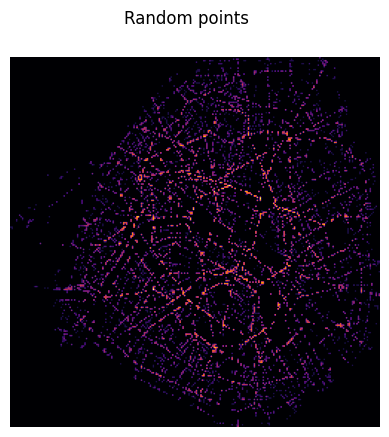

In [157]:
T=route_generator_v0(G,n=1000,debug=False)
fig = heatmap_from_tracks(T,G,quality_points=250)
fig.suptitle("Random points");

# Data generator class

Repeating 5th trajectory...
Repeating 31th trajectory...
Repeating 54th trajectory...
Repeating 82th trajectory...
Generation done.


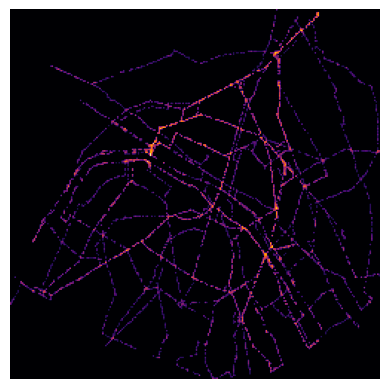

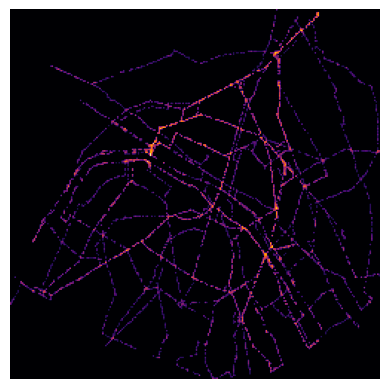

In [104]:
from numpy.random import choice
import pandas as pd
import osmnx as ox
import networkx as nx
from datetime import datetime
import numpy as np

class DataGenerator:
    def __init__(self,G=None,data=None,clip_dates=True):
        
        if data:
            self.data,self.station_data=data
        else:
            print("Loading data...")
            self.load_data(clip_dates=clip_dates)

        if G:
            self.G=G
        else:
            print("Loading map...")
            self.load_map()
        
        if 'closest_node' not in self.station_data.columns:
            print("Linking stations to nodes...")
            self.link_stations_to_nodes()

        self.T=[]

    def track_generator(self,n_tracks,sampling_rate=1,
                        max_iter_factor=10,
                        start_day=False,end_day=False,
                        start_h=0,end_h=23,
                        debug=False,**kwargs):
        """
        Generates a list of routes with points selected with the node_selector
        and with time simulated by the time_generator.
        This generates random days and hours within the input, not a sequence!

        Returns a list of n trajectories T.
        Each trajectory T[i] is a list of list elements in the format:
        [[timestamp, edge_start_node, edge_end_node, edge_osmid], ...]

        If there is not a path between selected nodes (not connected graph) it retries new nodes.
        A budget of n*max_iter_factor retries is set to avoid infinite loop.
        """

        #Select the datetimes to use
        available_days=self.data["day"].unique()
        if start_day:
            available_days=available_days[available_days>=start_day]
        if end_day:
            available_days=available_days[available_days<=end_day]
        sub_data=self.data[self.data["day"].isin(available_days)]
        
        counts_per_day=sub_data.groupby("day")["counts"].sum()
        stations_per_day=sub_data.groupby("day")["id"].count()
        c_per_available_day=counts_per_day/stations_per_day
        p_per_available_day=self.probability_from_counts(c_per_available_day)
        
        available_hours=[*range(start_h,end_h+1)]

        T=[]
        max_counts=n_tracks*max_iter_factor
        counts=0
        while len(T)<n_tracks:
            try:
                day=choice(available_days,p=p_per_available_day)
                day_data=self.data[self.data["day"].values==day]
                day_data_available=day_data[day_data["hour"].isin(available_hours)]
                c_per_available_hour=day_data_available.groupby("hour")["counts"].sum()
                p_per_available_hour=self.probability_from_counts(c_per_available_hour)
                hour=choice(available_hours,p=p_per_available_hour)
                
                date=pd.Timestamp(year=day.year,month=day.month,day=day.day,hour=hour)
                
                orig, dest = self.node_selector(date,**kwargs)
                track=nx.shortest_path(self.G, orig, dest, weight='length')

                t=date.timestamp()
                extended_track=self.time_generator(track,t,sampling_rate=sampling_rate,**kwargs)
                T.append(extended_track)

            except nx.exception.NetworkXNoPath:
                if debug:
                    print(f"Repeating {len(T)}th trajectory...")
                else:
                    pass

            counts+=1
            if counts==max_counts:
                print(f"WARNING: Not all tracks could be generated in {max_counts} iteratons.",
                      f"\nReturning {len(T)} tracks.")
                break

        if debug:
            print("Generation done.")
        self.T=T
        return T
    
    def edges_to_nodes(self,track):
        return [edge[0] for edge in track]

    def nodes_to_edges(self,track):
        return [(track[i],track[i+1]) for i in range(len(track)-1)]
    
    def node_selector(self,date,**kwargs):
        """
        Selects two nodes at random from the map G with probability drawn from data
        """
        nodes,p=self.get_p(date)
        orig=choice(nodes,p=p)
        orig_index=nodes.index(orig)
        nodes.pop(orig_index)
        p.pop(orig_index)
        p=self.probability_from_counts(p) #Removed one item,renormalize
        dest=choice(nodes,p=p)
        return orig, dest

    def get_p(self,date):
        """
        Retrieves the nodes and relative frequency of counts for a given date,
        using only the nodes with a counter.
        *Note that all dates don't have info for all counters, need to use the returned nodes
        """
        date_subdata=self.data[self.data["date"].values==date]
        counts=date_subdata.groupby("id")['counts'].sum()

        nodes=self.station_data.loc[counts.index,"closest_node"].to_list()
        p=self.probability_from_counts(counts)
        return nodes,p

    def time_generator(self,track,start_t,sampling_rate=1,v0=20):
        """
        Adds timestemps to a list of nodes every samping_rate seconds
        simulating a movement at constant speed v0 [km/h]
        """   
        edge_list=self.nodes_to_edges(track)
        extended_track=[]
        edge_index=0
        t=start_t
        edge=edge_list[0]
        l_excess=0
        done=False
        while not done:
            
            l_excess+=sampling_rate*(v0/3.6)

            edge, l_excess, depth, done = self.l_excess_backtrack(edge_index,edge_list,l_excess)
            edge_index+=depth
            
            osmid=self.G[edge[0]][edge[1]][0]['osmid']
            x=[t,edge[0],edge[1],osmid]
            extended_track.append(x)

            t+=sampling_rate

        return extended_track

    def load_data(self,clip_dates=False):
        raw_data=pd.read_csv("comptage-velo-donnees-compteurs.csv",sep=";")

        data=raw_data.loc[:,["id","sum_counts","date","coordinates"]]
        data=data.rename(columns={"sum_counts":"counts"})
        #But some counters multiple subcounters. Aggregate!!

        data=data.drop(data[data.coordinates.isnull()].index,axis=0)
        #TODO: there are counters with isnull().sum()!=0 Always the same? Interpolate or equal 0?

        data=data.astype({"id":int})

        #Only care relative time (people always go to work at 8am, dont care about UTC)
        split_date=data["date"].str.split("+",expand=True)
        data["date"]=split_date[0]
        data["UTC+"]=split_date[1]
        data["date"]=pd.to_datetime(data['date'])

        data["day"]=data['date'].dt.date
        data["hour"]=data["date"].dt.hour #Since data.date.dt.minute.sum()=0, dont care about else

        data[["lat","lon"]]=data["coordinates"].str.split(",",expand=True).astype(float)
        data["coordinates"]=data["coordinates"].str.split(",",expand=False)
        data["coordinates"].apply(lambda x: [float(x[0]),float(x[1])])

        data["weekend"]=data["date"].dt.weekday>4

        unique_index=[data[data["id"]==_id].index[0] for _id in data["id"].unique()]
        station_data=data.loc[unique_index,['id','coordinates','lat','lon']]
        station_data=station_data.set_index("id")

        if clip_dates:
            #Clip from the left where not all stations implemented
            max_stations_day=data.groupby("day")["id"].count().idxmax()
            data=data[data["day"].values>max_stations_day]
            #Clip from right where counts stop being constant
            max_stations_by_date=data.groupby("date")["id"].count().max()
            counts_by_date=data.groupby("date")["id"].count()
            errors=counts_by_date[counts_by_date.values<max_stations_by_date/2] #When it drops to half, it is bad
            first_error_day=errors.index[0].date()
            data=data[data["day"].values<first_error_day]

        self.data=data
        self.station_data=station_data

    def link_stations_to_nodes(self):
        X=self.station_data["lon"]
        Y=self.station_data["lat"]
        self.station_data["closest_node"]=None
        self.station_data["node_distance"]=np.inf
        for node in self.G.nodes():
            node_data=self.G.nodes[node]
            x_0=node_data['x']
            y_0=node_data['y']
            d_2=(X-x_0)**2+(Y-y_0)**2

            better_index=d_2<self.station_data["node_distance"]
            self.station_data.loc[better_index,"closest_node"]=node
            self.station_data.loc[better_index,"node_distance"]=d_2
        self.station_data=self.station_data.drop("node_distance",axis=1)

    def load_map(self):
        self.G = ox.graph_from_place('Paris, France', network_type='bike',simplify=False,retain_all=False)

    def l_excess_backtrack(self,index,edges,l_excess,depth=0):
        """
        Given a list of edges and a length recursively traverses the
        edges until the length is covered

        Returns the next edge after traversing l_excess, current l_excess (<l),
        the depth of the backtrack return and a control bool that states if the track is finished.
        If l_excess is bigger than the remaining track length, returns last edge in the track with
        control bool True.
        """
        
        edge=edges[index]
        edge_info=self.G[edge[0]][edge[1]][0]
        l=edge_info["length"]
        if l_excess>l:
            l_excess-=l
            if (index+1)<len(edges):
                return self.l_excess_backtrack(index+1,edges,l_excess,depth+1)
            else:
                return edge, l_excess, depth, True
        else:
            return edge, l_excess, depth, False

    def probability_from_counts(self,counts):
        """
        Creates a probability from counts adding up to 1 (avoiding rounding errors)
        """
        p=np.array(counts)/sum(counts)
        p=list(p)
        p[-1] = 1 - sum(p[0:-1]) #subtraction round errors smaller than normalization round errors.
        return p
        
# data_gen=DataGenerator(data=(data_gen.data,data_gen.station_data),G=data_gen.G)
# T=data_gen.track_generator(n_tracks=100,debug=True)
# heatmap_from_tracks(T,data_gen.G,quality_points=250)